# Rosembrock Target Practice

## MCHMC

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
target = RosenbrockTarget(0.5, 1.0, 100.0; d=4);

In [30]:
spl = MCHMC(0.0, 0.0005*0.5; init_eps=0.0005, varE_wanted=5.0, sigma=ones(target.d))

MicroCanonicalHMC.Sampler(Settings(MersenneTwister(0), 5.0, 0, 1000, 100, "LF", 0.0005, nothing, nothing), Hyperparameters(0.0, 0.00025, 0.0, 0.1931833275037836, [1.0, 1.0, 1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [31]:
samples_mchmc = Sample(spl, target, 10_000;
                       monitor_energy=true, 
                       dialog=true);

[ Info: Tuning eps ⏳


eps: 0.0005 --> VarE: 4.627407238892542
eps: 0.0007257465575036934 --> VarE: 18.259264436254586
eps: 2.416580826528753e-9 --> VarE: 3.357409674376954e-12
eps: 2.2285932653334246e-7 --> VarE: 3.575338423353491e-8
eps: 1.6482930364549262e-5 --> VarE: 0.006964005972877794
eps: 0.0009826740140450642 --> VarE: 67.89287631694846
eps: 5.250760289819004e-25 --> VarE: 0.0
eps: 2.1324974415639322e-23 --> VarE: 0.0
eps: 7.229350197354e-22 --> VarE: 0.0
eps: 2.0638624447996965e-20 --> VarE: 0.0
eps: 5.003485980230158e-19 --> VarE: 0.0
eps: 1.0383344906142563e-17 --> VarE: 0.0
eps: 1.8585227226805992e-16 --> VarE: 2.2163551853521739e-23
eps: 2.8899957297018315e-15 --> VarE: 3.901369952020992e-23
eps: 3.9310195327265606e-14 --> VarE: 9.213384541666122e-22
eps: 4.707891961525664e-13 --> VarE: 1.274663295072935e-19
eps: 4.995252253349708e-12 --> VarE: 1.4335729480106663e-17
eps: 4.723488613362769e-11 --> VarE: 1.2819843818136176e-15
eps: 4.002972484784356e-10 --> VarE: 9.207861596970241e-14
eps: 3.056

[ Info: Found eps: 0.0005074269108509697 ✅


In [32]:
rosenbrock_samples_mchmc = samples_mchmc[1000:end]

9002-element Vector{Any}:
 [0.07801206169905092, 1.1502523222260876, 0.39176103342967433, 0.8082436779578114, -18.624152252741624, -54203.1484881119]
 [0.0781986817639276, 1.149965656038888, 0.3913945525021825, 0.8081651333963045, -50.069017930967675, -54179.92849739815]
 [0.07821989024817846, 1.1503632045602696, 0.39115250551529773, 0.8083661326483896, 12.399838854653353, -54215.4144313117]
 [0.07853169934671111, 1.1501973858360208, 0.39122627704803986, 0.8087229506237964, 36.43431199565384, -54216.32105948615]
 [0.07827779352236572, 1.1502192639137954, 0.3909970899823201, 0.8090971277754758, 15.917739576769236, -54231.23261497685]
 [0.07794226352219824, 1.150389631067441, 0.3913291474499001, 0.8090221974076242, 24.67453358302737, -54240.69878559703]
 [0.07830303764038804, 1.1506380546418786, 0.39155773305260144, 0.8089066186232323, 22.934786278376123, -54254.28426590354]
 [0.07790329807370844, 1.150488987328064, 0.39129448258811655, 0.8089851582793759, 5.801612915514852, -54246.45901

In [33]:
d1_mchmc = [sample[1] for sample in samples_mchmc]
d2_mchmc = [sample[2] for sample in samples_mchmc];

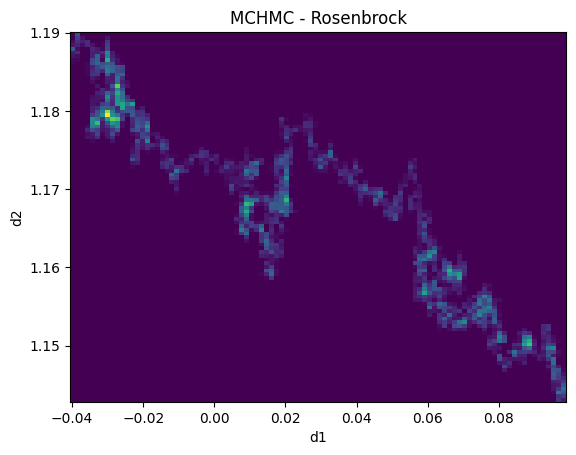

In [34]:
plt.hist2d(d1_mchmc, d2_mchmc, bins=100);
plt.xlabel("d1")
plt.ylabel("d2")
plt.title("MCHMC - Rosenbrock");

## NUTS

In [11]:
using AdvancedHMC
using LogDensityProblems

In [12]:
# Define the target distribution using the `LogDensityProblem` interface
struct LogTargetDensity
    dim::Int
end
LogDensityProblems.logdensity(p::LogTargetDensity, θ) = -rosenbrock_target.nlogp(θ) #-sum(abs2, θ) / 2  # standard multivariate normal
LogDensityProblems.dimension(p::LogTargetDensity) = p.dim
LogDensityProblems.capabilities(::Type{LogTargetDensity}) = LogDensityProblems.LogDensityOrder{0}()

MvNormal{Int64, PDMats.ScalMat{Int64}, FillArrays.Zeros{Int64, 1, Tuple{Base.OneTo{Int64}}}}(
dim: 2
μ: Zeros(2)
Σ: [1 0; 0 1]
)


In [13]:
# Choose parameter dimensionality and initial parameter value
initial_θ = ill_gaussian_target.prior_draw(0.0)
ℓπ = LogTargetDensity(d)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 100_000, 1_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(d)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = AdvancedHMC.Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
rosenbrock_samples_hmc, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)

In [14]:
struct HybridRosenbrock{Tμ,Ta,Tb,Td}
    μ::Tμ
    a::Ta
    b::Tb
    dim::Td
end

function LogDensityProblems.logdensity(D::HybridRosenbrock, x)
    n2, n1 = size(D.b)
    n = length(x)
    X = reshape(@view(x[2:end]), n1, n2)
    y = -D.a*(x[1] - D.μ)^2 
    for j in 1:n2 
        y -= D.b[j,1]*(X[j,1] - x[1]^2)^2
        for i in 2:n1
            y -= D.b[j,i]*(X[j,i] - X[j,i-1]^2)^2
        end
    end
    C = 0.5log(D.a) + 0.5sum(log.(D.b)) - n/2*log(pi)
    return y + C
end
LogDensityProblems.dimension(p::HybridRosenbrock) = p.dim
LogDensityProblems.capabilities(::Type{HybridRosenbrock}) = LogDensityProblems.LogDensityOrder{0}()

LoadError: UndefVarError: `LogDensityProblems` not defined

In [15]:
d = 5
Random.seed!(3)
σ0 = [10.136599898636616
    144.60096611643337
    144.60377635508613
    81881.51706273475
    81889.36757394506]

ℓπ = HybridRosenbrock(1, 1/20, 100/20*ones(2,2), d)

HybridRosenbrock{Int64, Float64, Matrix{Float64}, Int64}(1, 0.05, [5.0 5.0; 5.0 5.0], 5)

In [16]:
# Define a Hamiltonian system
metric = DiagEuclideanMetric(d)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
#initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
#initial_ϵ = 1e-2
#integrator = Leapfrog(initial_ϵ)

LoadError: UndefVarError: `DiagEuclideanMetric` not defined

In [17]:
# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
#adaptor = MassMatrixAdaptor(metric)


# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
#samples, stats = @time sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)

LoadError: UndefVarError: `AdvancedHMC` not defined

## Sampling

In [18]:
target = TuringTarget(stat_model; compute_MAP=true);

LoadError: UndefVarError: `TuringTarget` not defined

In [19]:
samples_mchmc = Sample(MCHMC(varE_wanted=1.0), target, 100000;
                       monitor_energy=true, 
                       dialog=true);

LoadError: UndefVarError: `MCHMC` not defined

In [20]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

LoadError: UndefVarError: `samples_mchmc` not defined

In [21]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

LoadError: UndefVarError: `Wms_mchmc` not defined

In [22]:
samples_ensemble_mchmc = Sample(MCHMC(100; varE_wanted=0.05), target, 1000, 100;
   monitor_energy=true, 
   dialog=true);

LoadError: UndefVarError: `MCHMC` not defined

In [23]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

LoadError: UndefVarError: `samples_ensemble_mchmc` not defined

In [24]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

LoadError: UndefVarError: `Wms_ensemble_mchmc` not defined

##  AbstractMCMC

In [25]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

LoadError: UndefVarError: `MCHMC` not defined

In [26]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

LoadError: UndefVarError: `MCHMC` not defined

## Ensemble AbstractMCMC

In [27]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

LoadError: UndefVarError: `stat_model` not defined

In [28]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

LoadError: UndefVarError: `MCHMC` not defined

## Parallelization

In [29]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

LoadError: UndefVarError: `MCHMC` not defined

In [30]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

LoadError: UndefVarError: `MCHMC` not defined

## NUTS

In [31]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

LoadError: UndefVarError: `stat_model` not defined

In [32]:
samples_hmc.value

LoadError: UndefVarError: `samples_hmc` not defined

In [33]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

LoadError: UndefVarError: `samples_hmc` not defined

In [34]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");

LoadError: UndefVarError: `Wms_hmc` not defined